In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
import os

current_dir = os.getcwd() 
parent_dir = os.path.join(current_dir, '..', '..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.plane_equation import PlaneEquation

In [2]:
def make_meshgrid(x, y, h=.01):
    x_min, x_max = x.min() , x.max()
    y_min, y_max = y.min() , y.max()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, xy, **params):
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


In [3]:
N=1000
C=1000
gamma=0.01
D=2 #dimension
t=8 #polytope order

X = np.random.normal(0,1,(N,D))
ws= np.random.normal(0,1,(t,D))
ws = ws / (np.linalg.norm(ws,axis=1).reshape(-1,1))

u=np.random.uniform(0,1,(N,1))
X=X/(np.linalg.norm(X,axis=1).reshape(-1,1))*(u**(1/D))

y=np.ones(N)

for index in range(N):
    z = 1
    for w in ws :
        if((X[index].dot(w)- 0.5 - gamma) > 0):
            z = -1
        else :
            if ((X[index].dot(w) - 0.4 -gamma) > 0):
                z =0
    y[index]=z

X=(X[y!= 0]+ [1,1])/2
y=y[y!= 0]

print("Dataset created:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {np.unique(y)}")


Dataset created:
X shape: (783, 2)
y shape: (783,)
Classes: [-1.  1.]


Running for subdivision_levels k=1
(783, 4)
Running for subdivision_levels k=2
(783, 7)
Running for subdivision_levels k=3
(783, 16)
Running for subdivision_levels k=4
(783, 43)


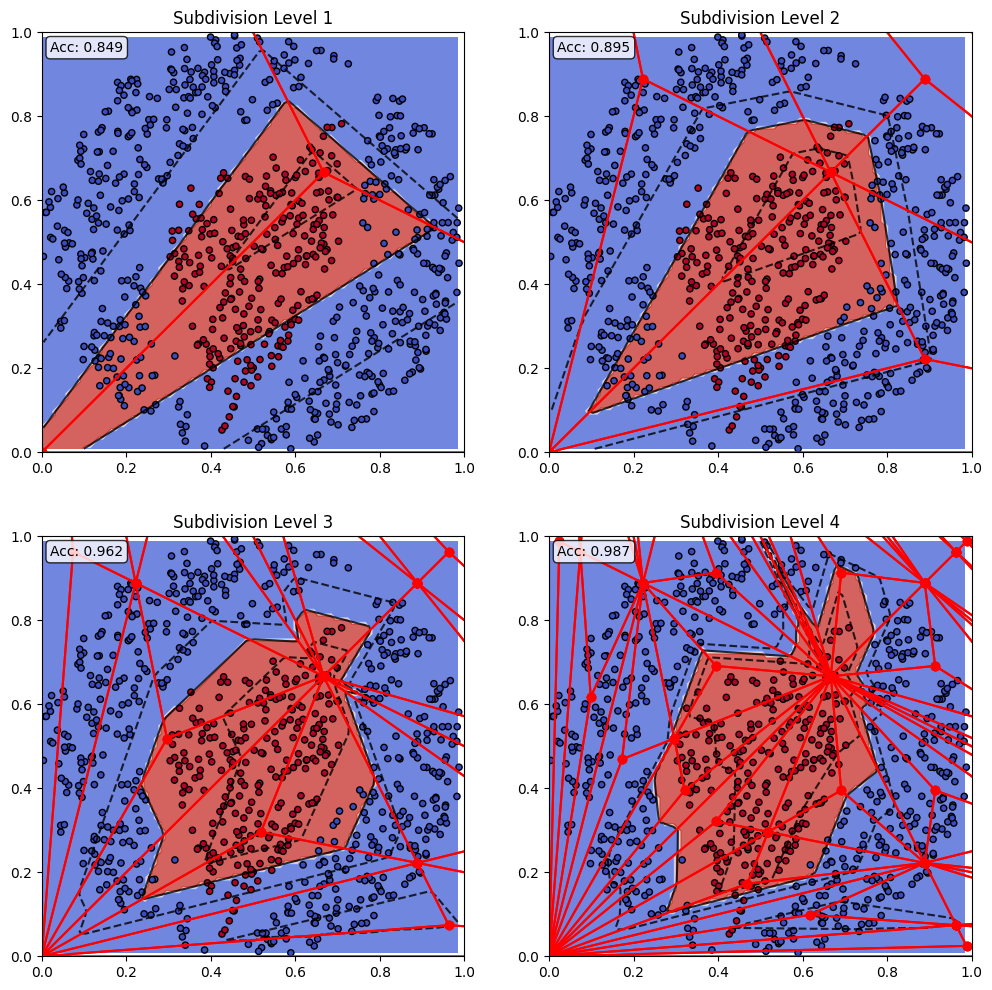

In [4]:
fig, sub = plt.subplots(2, 2, figsize=(12, 12))
xx, yy = make_meshgrid(X[:, 0], X[:, 1])

for k, title, ax in zip(range(1, 5), range(1, 5), sub.flatten()):
    print(f"Running for subdivision_levels k={k}")
    
    model = SimplexTreeClassifier(
        vertices=[(0, 0), (2, 0), (0, 2)], # Use a triangle that contains the [0,1]x[0,1] data space
        regularization=C,
        subdivision_levels=k,
        classifier_type='linear_svc'
    )
    
    model.fit(X, y)
    
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)

    plot_contours(ax, model.classifier, xx, yy, xy,
                 cmap=plt.cm.coolwarm, alpha=0.8)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"Subdivision Level {title}")

    # Use coef_[0] instead of decision_function
    if hasattr(model.classifier, "coef_"):
        weights = model.classifier.coef_[0]
        bias = model.classifier.intercept_[0]
        Z = (xy @ weights + bias).reshape(xx.shape)
        ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
                    linestyles=['--', '-', '--'])

    boundaries = model.get_simplex_boundaries()
    for boundary in boundaries:
        if len(boundary) >= 3:
            closed_boundary = boundary + [boundary[0]]
            x_coords = [point[0] for point in closed_boundary]
            y_coords = [point[1] for point in closed_boundary]
            ax.plot(x_coords, y_coords, 'ro-')
            
    accuracy = model.classifier.score(model.transform(X), y)
    ax.text(0.02, 0.98, f'Acc: {accuracy:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

### Redundent Planes Detection

In [5]:
MAX_SUBDIVISION = 4

CLEAR ADJACENCY VISUALIZATION TEST

Setup:
  Total leaf simplices: 9
  Testing simplex #8

Results:
  Test simplex has 3 adjacent simplices
  Test simplex vertices: ['(2.0,1.3)', '(2.0,4.0)', '(1.3,1.8)']


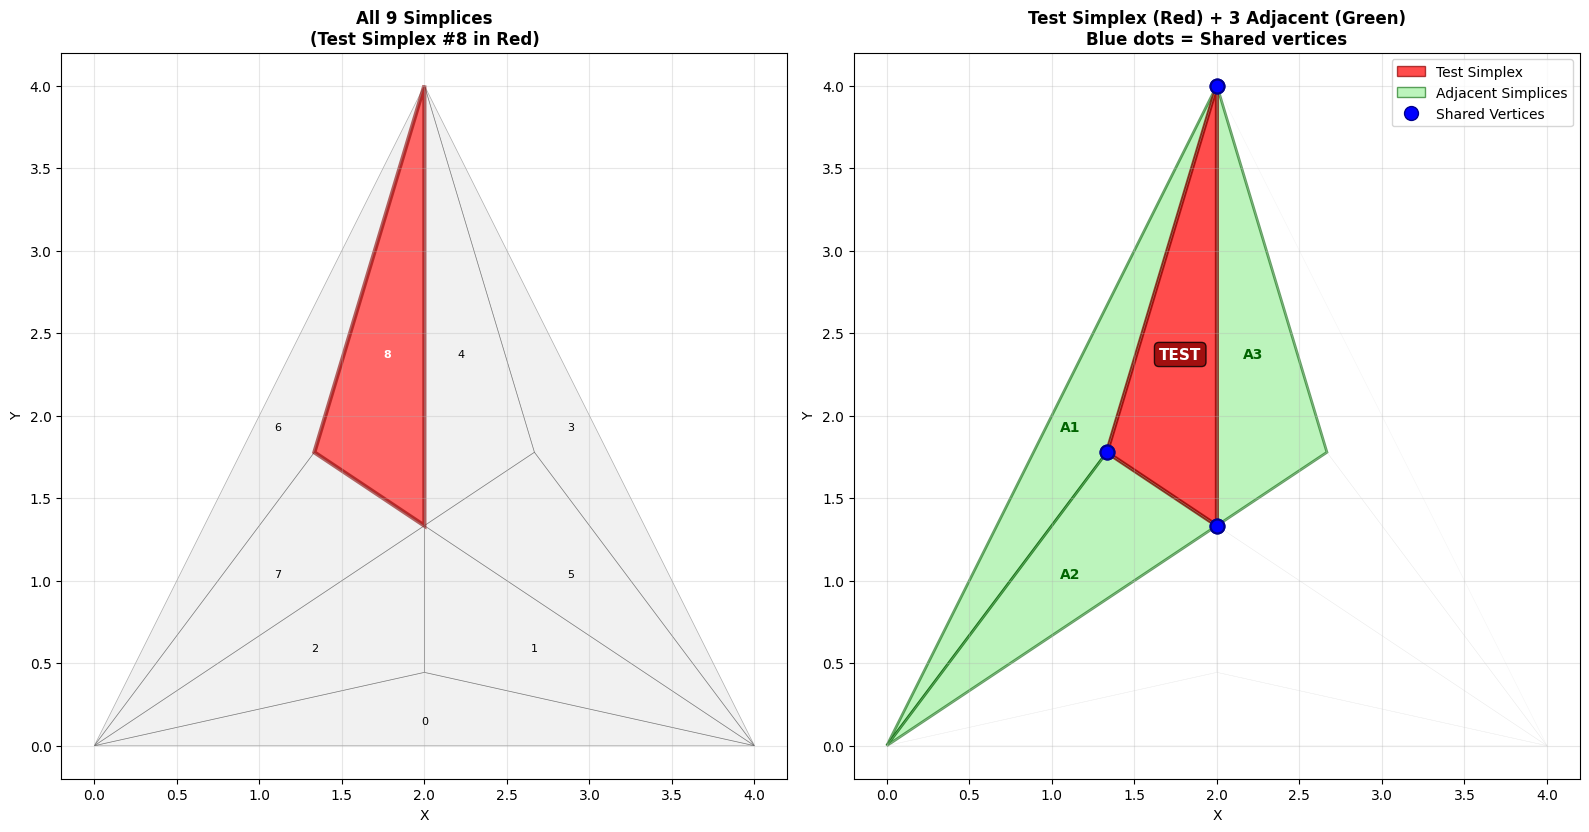


DETAILED ADJACENCY ANALYSIS

Simplex Properties:
  Dimension: 2D
  Maximum possible adjacent: 3
  Actually found: 3

Adjacent #1 (A1):
  Shared vertices: 2/2 needed for adjacency
  Tree depth: 2
  Vertices: ['(2.0,4.0)', '(0.0,0.0)', '(1.3,1.8)']
  ✓ Forms valid 1D face

Adjacent #2 (A2):
  Shared vertices: 2/2 needed for adjacency
  Tree depth: 2
  Vertices: ['(0.0,0.0)', '(2.0,1.3)', '(1.3,1.8)']
  ✓ Forms valid 1D face

Adjacent #3 (A3):
  Shared vertices: 2/2 needed for adjacency
  Tree depth: 2
  Vertices: ['(2.0,4.0)', '(2.0,1.3)', '(2.7,1.8)']
  ✓ Forms valid 1D face

Test complete! Blue dots show the shared vertices between simplices.


In [6]:
print("="*60)
print("CLEAR ADJACENCY VISUALIZATION TEST")
print("="*60)

vertices = [(0, 0), (4, 0), (2, 4)]
subdivision_level = 2
test_simplex_idx = 8

classifier = SimplexTreeClassifier(vertices=vertices, subdivision_levels=subdivision_level)
all_leaves = classifier.tree.get_leaves()

print(f"\nSetup:")
print(f"  Total leaf simplices: {len(all_leaves)}")
print(f"  Testing simplex #{test_simplex_idx}")

test_simplex = all_leaves[test_simplex_idx % len(all_leaves)]
adjacent_simplices = classifier.find_adjacent_simplices(test_simplex.vertices)

print(f"\nResults:")
print(f"  Test simplex has {len(adjacent_simplices)} adjacent simplices")
print(f"  Test simplex vertices: {[f'({v[0]:.1f},{v[1]:.1f})' for v in test_simplex.vertices]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.set_title(f'All {len(all_leaves)} Simplices\n(Test Simplex #{test_simplex_idx} in Red)', 
              fontsize=12, fontweight='bold')

for i, leaf in enumerate(all_leaves):
    vertices_array = np.array(leaf.vertices)
    vertices_closed = np.vstack([vertices_array, vertices_array[0]])
    
    if leaf == test_simplex:
        ax1.fill(vertices_array[:, 0], vertices_array[:, 1], 
                color='red', alpha=0.6, edgecolor='darkred', linewidth=3)
    else:
        ax1.fill(vertices_array[:, 0], vertices_array[:, 1], 
                color='lightgray', alpha=0.3, edgecolor='black', linewidth=0.5)
    
    centroid = np.mean(vertices_array, axis=0)
    color = 'white' if leaf == test_simplex else 'black'
    weight = 'bold' if leaf == test_simplex else 'normal'
    ax1.text(centroid[0], centroid[1], str(i), 
            ha='center', va='center', fontsize=8, color=color, fontweight=weight)

ax2.set_title(f'Test Simplex (Red) + {len(adjacent_simplices)} Adjacent (Green)\nBlue dots = Shared vertices', 
              fontsize=12, fontweight='bold')

for leaf in all_leaves:
    vertices_array = np.array(leaf.vertices)
    vertices_closed = np.vstack([vertices_array, vertices_array[0]])
    ax2.plot(vertices_closed[:, 0], vertices_closed[:, 1], 
            color='lightgray', linewidth=0.3, alpha=0.3)

adjacent_vertex_sets = [set(tuple(v) for v in adj) for adj in adjacent_simplices]

test_vertices_set = set(tuple(v) for v in test_simplex.vertices)
for adj_idx, adj_vertices in enumerate(adjacent_simplices):
    adj_array = np.array(adj_vertices)
    ax2.fill(adj_array[:, 0], adj_array[:, 1], 
            color='lightgreen', alpha=0.6, edgecolor='darkgreen', linewidth=2)
    
    centroid = np.mean(adj_array, axis=0)
    ax2.text(centroid[0], centroid[1], f'A{adj_idx+1}', 
            ha='center', va='center', fontsize=10, 
            color='darkgreen', fontweight='bold')
    
    adj_vertices_set = set(tuple(v) for v in adj_vertices)
    shared_vertices = test_vertices_set.intersection(adj_vertices_set)
    for vertex in shared_vertices:
        ax2.plot(vertex[0], vertex[1], 'o', 
                color='blue', markersize=10, 
                markeredgecolor='darkblue', markeredgewidth=1.5)

test_vertices_array = np.array(test_simplex.vertices)
ax2.fill(test_vertices_array[:, 0], test_vertices_array[:, 1], 
        color='red', alpha=0.7, edgecolor='darkred', linewidth=3)

test_centroid = np.mean(test_vertices_array, axis=0)
ax2.text(test_centroid[0], test_centroid[1], 'TEST', 
        ha='center', va='center', fontsize=11, color='white', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='darkred', alpha=0.8))

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

legend_elements = [
    Patch(facecolor='red', alpha=0.7, edgecolor='darkred', label='Test Simplex'),
    Patch(facecolor='lightgreen', alpha=0.6, edgecolor='darkgreen', label='Adjacent Simplices'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
           markersize=10, markeredgecolor='darkblue', label='Shared Vertices')
]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DETAILED ADJACENCY ANALYSIS")
print("="*60)

dimension = len(test_simplex.vertices) - 1
print(f"\nSimplex Properties:")
print(f"  Dimension: {dimension}D")
print(f"  Maximum possible adjacent: {dimension + 1}")
print(f"  Actually found: {len(adjacent_simplices)}")

for i, adj_vertices in enumerate(adjacent_simplices):
    adj_set = set(tuple(v) for v in adj_vertices)
    shared = test_vertices_set.intersection(adj_set)
    
    adj_node = classifier._get_simplex_node(adj_vertices)
    
    print(f"\nAdjacent #{i+1} (A{i+1}):")
    print(f"  Shared vertices: {len(shared)}/{dimension} needed for adjacency")
    print(f"  Tree depth: {adj_node.depth if adj_node else 'unknown'}")
    print(f"  Vertices: {[f'({v[0]:.1f},{v[1]:.1f})' for v in adj_vertices]}")
    if len(shared) == dimension:
        print(f"  ✓ Forms valid {dimension-1}D face")

print("\n" + "="*60)
print("Test complete! Blue dots show the shared vertices between simplices.")
print("="*60)


In [7]:
cols = 2
rows = int(np.ceil(MAX_SUBDIVISION / cols))

In [8]:
model = SimplexTreeClassifier(
    vertices=[(0, 0), (2, 0), (0, 2)],
    regularization=C,
    subdivision_levels=2,  # Test with level 2
    classifier_type='linear_svc'
)

model.fit(X, y)
weights = model.classifier.coef_[0]

print("Checking all leaf simplices for decision boundaries:")
print("=" * 60)

all_leaves = model.leaf_simplexes
simplices_with_boundaries = []

for i, leaf in enumerate(all_leaves):
    vertices = leaf.get_vertices_as_tuples()
    vertex_matrix = model.transform(np.array(vertices))
    decision_values = vertex_matrix @ weights
    
    has_positive = any(val > 0 for val in decision_values)
    has_negative = any(val < 0 for val in decision_values)
    
    print(f"\nSimplex {i+1}:")
    print(f"  Vertices: {[f'({v[0]:.2f},{v[1]:.2f})' for v in vertices]}")
    print(f"  Decision values: {[f'{val:.4f}' for val in decision_values]}")
    print(f"  Has positive: {has_positive}, Has negative: {has_negative}")
    
    if has_positive and has_negative:
        print(f"  ✓ Has decision boundary!")
        simplices_with_boundaries.append(leaf)

print(f"\n{len(simplices_with_boundaries)} out of {len(all_leaves)} simplices have decision boundaries")

# Compare with what compute_svm_plane_equations finds
plane_equations = model.compute_svm_plane_equations()
print(f"compute_svm_plane_equations found: {len(plane_equations)} simplices")


(783, 7)
Checking all leaf simplices for decision boundaries:

Simplex 1:
  Vertices: ['(0.00,0.00)', '(2.00,0.00)', '(0.89,0.22)']
  Decision values: ['4.8540', '-13.8187', '4.3968']
  Has positive: True, Has negative: True
  ✓ Has decision boundary!

Simplex 2:
  Vertices: ['(2.00,0.00)', '(0.67,0.67)', '(0.89,0.22)']
  Decision values: ['-13.8187', '6.9740', '4.3968']
  Has positive: True, Has negative: True
  ✓ Has decision boundary!

Simplex 3:
  Vertices: ['(0.67,0.67)', '(0.00,0.00)', '(0.89,0.22)']
  Decision values: ['6.9740', '4.8540', '4.3968']
  Has positive: True, Has negative: False

Simplex 4:
  Vertices: ['(2.00,0.00)', '(0.00,2.00)', '(0.89,0.89)']
  Decision values: ['-13.8187', '-12.6484', '2.2927']
  Has positive: True, Has negative: True
  ✓ Has decision boundary!

Simplex 5:
  Vertices: ['(0.00,2.00)', '(0.67,0.67)', '(0.89,0.89)']
  Decision values: ['-12.6484', '6.9740', '2.2927']
  Has positive: True, Has negative: True
  ✓ Has decision boundary!

Simplex 6:
  

In [9]:
model.tree.print_tree()

└── (0.00, 0.00), (2.00, 0.00), (0.00, 2.00)
    ├── (0.00, 0.00), (2.00, 0.00), (0.67, 0.67)
    │   ├── (0.00, 0.00), (2.00, 0.00), (0.89, 0.22)
    │   ├── (2.00, 0.00), (0.67, 0.67), (0.89, 0.22)
    │   └── (0.67, 0.67), (0.00, 0.00), (0.89, 0.22)
    ├── (2.00, 0.00), (0.00, 2.00), (0.67, 0.67)
    │   ├── (2.00, 0.00), (0.00, 2.00), (0.89, 0.89)
    │   ├── (0.00, 2.00), (0.67, 0.67), (0.89, 0.89)
    │   └── (0.67, 0.67), (2.00, 0.00), (0.89, 0.89)
    └── (0.00, 2.00), (0.00, 0.00), (0.67, 0.67)
        ├── (0.00, 2.00), (0.00, 0.00), (0.22, 0.89)
        ├── (0.00, 0.00), (0.67, 0.67), (0.22, 0.89)
        └── (0.67, 0.67), (0.00, 2.00), (0.22, 0.89)


## Crossed Plane Detection



Subdivision Level 1:
(783, 4)
✅ CONVEX (outward bend) (Target-Adjacent): plane_dot=-0.2868, angle_dot=1.2222
✅ CONVEX (outward bend) (Target-Adjacent): plane_dot=-0.9317, angle_dot=-1.1111
  Non-convex pairs: 0
  SVM operates in 4D barycentric space
  Weights shape: (4,)
  Bias: -2.732
  Found 3 simplices crossed by TRUE SVM boundary
  (Out of 3 total leaf simplices)

Subdivision Level 2:
(783, 7)
✅ OK (Target-Adjacent): dot=0.1023 at (0.96,0.07) & (1.19,0.30)
✅ OK (Target-Adjacent): dot=0.9966 at (0.96,0.07) & (0.52,0.30)
✅ OK (Adjacent-Adjacent): dot=0.1834 at (1.19,0.30) & (0.52,0.30)
✅ OK (Target-Adjacent): dot=0.9987 at (1.19,0.30) & (1.19,0.52)
✅ OK (Adjacent-Adjacent): dot=0.1338 at (0.52,0.30) & (1.19,0.52)
✅ CONVEX (outward bend) (Target-Adjacent): plane_dot=-0.7542, angle_dot=-0.1235
✅ OK (Target-Adjacent): dot=0.8560 at (0.96,0.96) & (0.52,1.19)
✅ OK (Target-Adjacent): dot=0.8393 at (0.96,0.96) & (1.19,0.52)
✅ OK (Adjacent-Adjacent): dot=0.4374 at (0.52,1.19) & (1.19,0.52)


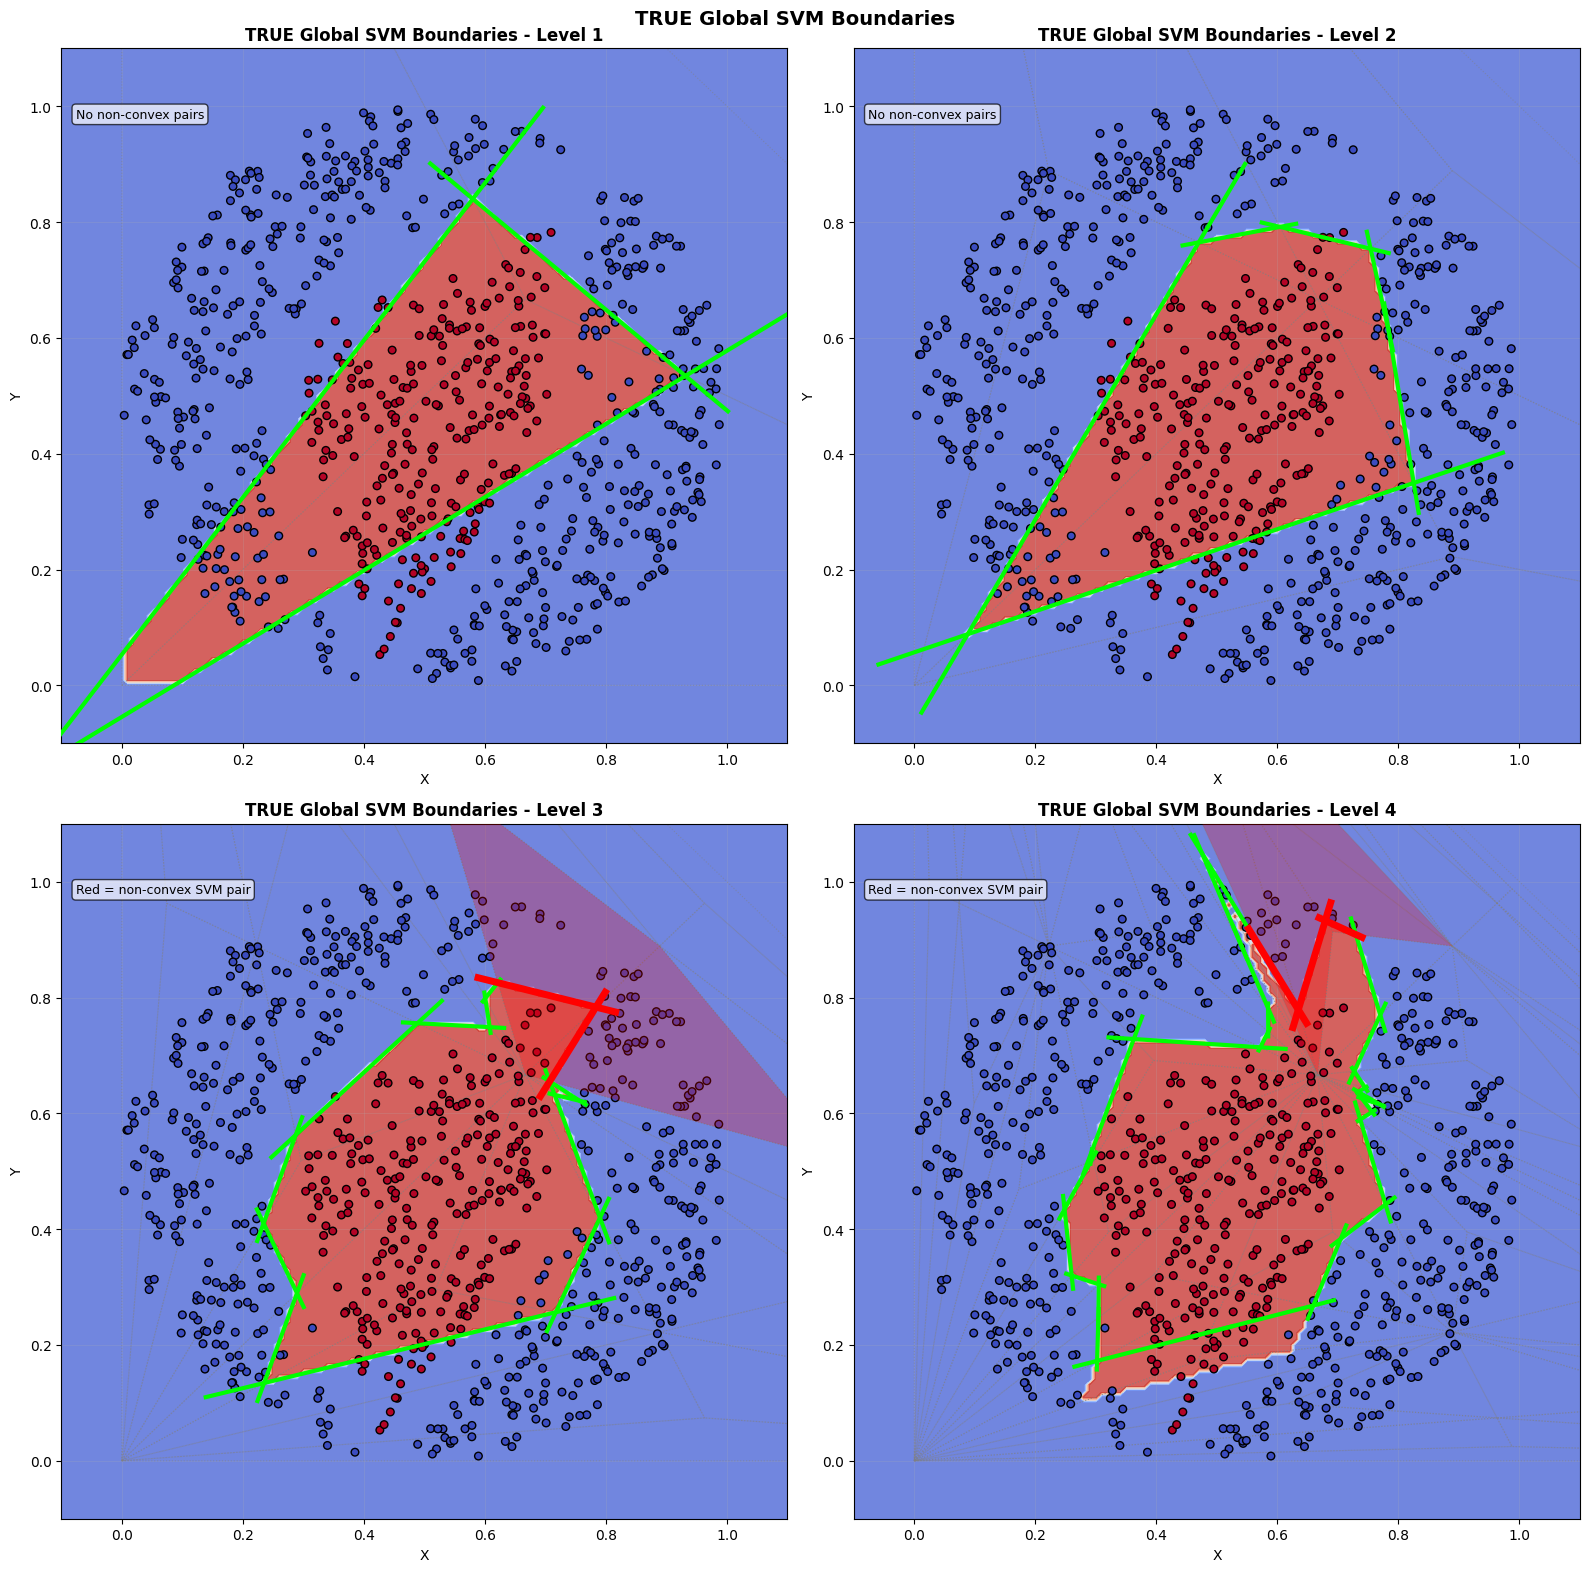

In [ ]:
cols = 2
rows = int(np.ceil(MAX_SUBDIVISION / cols))
fig, sub = plt.subplots(rows, cols, figsize=(cols*8, rows*8))
axes = np.atleast_1d(sub).ravel()

from matplotlib import patches

x_min, x_max = -0.1, 1.1  
y_min, y_max = -0.1, 1.1
xx, yy = make_meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

for k, ax in zip(range(1, MAX_SUBDIVISION + 1), axes):
    print(f"\nSubdivision Level {k}:")
    
    model = SimplexTreeClassifier(
        vertices=[(0, 0), (2, 0), (0, 2)],
        regularization=C,
        subdivision_levels=k,
        classifier_type='linear_svc'
    )
    
    model.fit(X, y)
    
    model.clear_pairs_cache()
    nonconvex_pairs = []
    for leaf_simplex in model.leaf_simplexes:
        result = model.find_nonconvex_simplices(np.array(leaf_simplex.vertices), angle_threshold=90)
        for pair in result['nonconvex_pairs']:
            if pair.get('type') == 'non-convex':
                nonconvex_pairs.append(pair)
    nonconvex_simplex_keys = set()
    for pair in nonconvex_pairs:
        target_key = frozenset(tuple(v) for v in pair['target']['vertices'])
        adjacent_key = frozenset(tuple(v) for v in pair['adjacent']['vertices'])
        nonconvex_simplex_keys.add(target_key)
        nonconvex_simplex_keys.add(adjacent_key)
    print(f"  Non-convex pairs: {len(nonconvex_pairs)}")
    
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)

    plot_contours(ax, model.classifier, xx, yy, xy,
                 cmap=plt.cm.coolwarm, alpha=0.8)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, 
               edgecolors='k', linewidth=1, zorder=5)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"TRUE Global SVM Boundaries - Level {k}", fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.2)

    boundaries = model.get_simplex_boundaries()
    for boundary in boundaries:
        if len(boundary) >= 3:
            closed_boundary = boundary + [boundary[0]]
            x_coords = [point[0] for point in closed_boundary]
            y_coords = [point[1] for point in closed_boundary]
            ax.plot(x_coords, y_coords, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)
    
    num_boundaries_found = 0
    
    weights = model.classifier.coef_[0]  # Weight vector in barycentric space
    bias = model.classifier.intercept_[0]  # Bias term
    
    print(f"  SVM operates in {len(weights)}D barycentric space")
    print(f"  Weights shape: {weights.shape}")
    print(f"  Bias: {bias:.3f}")
    
    for leaf in model.leaf_simplexes:
        vertices = np.array(leaf.vertices)
        simplex_key = frozenset(tuple(v) for v in vertices)
        is_nonconvex_simplex = simplex_key in nonconvex_simplex_keys
        
        if is_nonconvex_simplex:
            ax.add_patch(patches.Polygon(vertices, closed=True, facecolor='red', alpha=0.25, edgecolor='none', zorder=6))
        
        vertex_decisions = []
        for v in vertices:
            # Transform to barycentric coordinates
            v_transformed = model.transform(np.array([v]))
            
            decision_val = (v_transformed @ weights + bias)[0]
            vertex_decisions.append(decision_val)
        
        # Check if the TRUE SVM boundary crosses this simplex
        # (it crosses if vertices have different signs)
        signs = np.sign(vertex_decisions)
        if len(np.unique(signs[signs != 0])) > 1:  # Different signs = boundary crosses
            num_boundaries_found += 1
            
            # Find intersection points with edges
            intersections = []
            for i in range(3):
                v1 = vertices[i]
                v2 = vertices[(i+1) % 3]
                val1 = vertex_decisions[i]
                val2 = vertex_decisions[(i+1) % 3]
                
                if val1 * val2 < 0:  # Boundary crosses this edge
                    # Interpolate to find exact intersection
                    t = -val1 / (val2 - val1)
                    intersection = v1 + t * (v2 - v1)
                    intersections.append(intersection)
            
            if len(intersections) == 2:
                # Extend the line slightly for visibility
                direction = intersections[1] - intersections[0]
                direction_norm = direction / np.linalg.norm(direction)
                
                extension_length = 0.2 * np.linalg.norm(direction)
                start = intersections[0] - extension_length * direction_norm
                end = intersections[1] + extension_length * direction_norm
                
                # Draw the TRUE boundary, highlight if non-convex
                line_color = 'red' if is_nonconvex_simplex else 'lime'
                line_width = 5 if is_nonconvex_simplex else 3
                line_zorder = 30 if is_nonconvex_simplex else 20
                ax.plot([start[0], end[0]], [start[1], end[1]], 
                       color=line_color, linewidth=line_width, alpha=1.0, 
                       zorder=line_zorder)
    
    if nonconvex_pairs:
        ax.text(0.02, 0.9, 'Red = non-convex SVM pair', transform=ax.transAxes,
                fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax.text(0.02, 0.9, 'No non-convex pairs', transform=ax.transAxes,
                fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    print(f"  Found {num_boundaries_found} simplices crossed by TRUE SVM boundary")
    print(f"  (Out of {len(model.leaf_simplexes)} total leaf simplices)")

# Hide any unused subplots
for ax in axes[MAX_SUBDIVISION:]:
    ax.axis('off')

plt.suptitle('TRUE Global SVM Boundaries', 
             fontsize=14, fontweight='bold')            
plt.tight_layout()
plt.show()
